# INTELIGENCIA ARTIFICIAL (1INF24)
Dr. Edwin Villanueva Talavera (ervillanueva@pucp.edu.pe)

## Ejemplo de implementación de algoritmos heurísticos de búsqueda de rutas en mapas
En este notebook se implementa y compara métodos de búsqueda sin y con información (A*) para rutas en mapas. Abajo puede encontrar la definición de la clase Mapa y una instancia específica con el mapa de Romania que será usado en las pruebas.

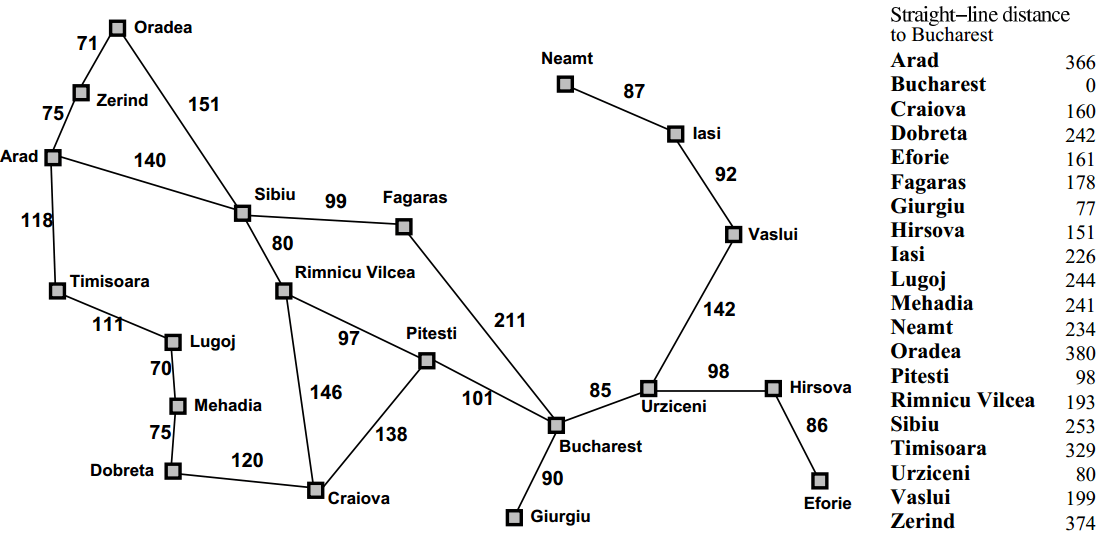

### Clase Mapa
Estructura para almacenar información de un mapa. Tiene dos atributos: <b>neighbors</b> (diccionario que contiene las ciudades vecinas de cada ciudad y las distancias para llegar a ellas) y <b>location</b>, diccionario con las coordenadas X, Y de cada ciudad.

In [1]:
class Mapa:
    def __init__(self, neighbors, location):
        self.neighbors = neighbors
        self.location = location


Instancia del mapa específico de Romania:

In [2]:
neighbors = {
    'A': [('Z',75), ('T', 118), ('S', 140)],
    'B': [('F', 211), ('P', 101), ('G', 90), ('U', 85)],
    'C': [('D', 120), ('R', 146), ('P', 138)],
    'D': [('M', 75), ('C', 120)],
    'E': [('H', 86)],
    'F': [('S', 99), ('B', 211)],
    'G': [('B', 90)],
    'H': [('U', 98), ('E', 86)],
    'I': [('N', 87), ('V', 92)],
    'L': [('T', 111), ('M', 70)],
    'M': [('L', 70), ('D', 75)],
    'N': [('I', 87)],
    'O': [('Z', 71), ('S', 151)],
    'P': [('R', 97), ('C', 138), ('B', 101)],
    'R': [('S', 80), ('C', 146), ('P', 97)],
    'S': [('A', 140), ('O', 151), ('F', 99), ('R', 80)],
    'T': [('A', 118), ('L', 111)],
    'U': [('B', 85), ('V', 142), ('H', 98)],
    'V': [('U', 142), ('I', 92)],
    'Z': [('O', 71), ('A', 75)]
}

location = {
    'A': (91, 492),
    'B': (400, 327),
    'C': (253, 288),
    'D': (165, 299),
    'E': (562, 293),
    'F': (305, 449),
    'G': (375, 270),
    'H': (534, 350),
    'I': (473, 506),
    'L': (165, 379),
    'M': (168, 339),
    'N': (406, 537),
    'O': (131, 571),
    'P': (320, 368),
    'R': (233, 410),
    'S': (207, 457),
    'T': (94, 410),
    'U': (456, 350),
    'V': (509, 444),
    'Z': (108, 531)
}

romania = Mapa(neighbors, location)


### Clase SearchProblem
Esta es una clase abstracta para definir problemas de búsqueda. Se debe hacer subclases que implementen los métodos de las acciones, resultados, test de objetivo y el costo de camino. Entonces, se puede instanciar las subclases y resolverlos con varias funciones de búsqueda.

In [3]:
class SearchProblem(object):
    def __init__(self, initial, goal=None):
        """Este constructor especifica el estado inicial y posiblemente el estado(s) objetivo(s),
        La subclase puede anhadir mas argumentos."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Retorna las acciones que pueden ser ejecutadas en el estado dado.
        El resultado es tipicamente una lista."""
        raise NotImplementedError

    def result(self, state, action):
        """Retorna el estado que resulta de ejecutar la accion dada en el estado state.
        La accion debe ser alguna de self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Retorna True si el estado pasado como argumento satisface el objetivo."""
        raise NotImplementedError

    def path_cost(self, c, state1, action, state2):
        """Retorna el costo del camino de state2 viniendo de state1 con
        la accion action, asumiendo un costo c para llegar hasta state1.
        El metodo por defecto cuesta 1 para cada paso en el camino."""
        return c + 1

    def value(self, state):
        """En problemas de optimizacion, cada estado tiene un valor. Algoritmos
        como Hill-climbing intentan maximizar este valor."""
        raise NotImplementedError


### Clase MapSearchProblem
Esta es una subclase de SearchProblem donde se define concretamente el problema de búsqueda en mapa. El constructor recibe el estado inicial, objetivo y un mapa.

In [4]:
class MapSearchProblem(SearchProblem):
    def __init__(self, initial, goal, mapa):
        """El constructor recibe  el estado inicial, el estado objetivo y un mapa (de clase Mapa)"""
        self.initial = initial
        self.goal = goal
        self.map = mapa

    def actions(self, state):
        """Retorna las acciones ejecutables desde ciudad state.
        El resultado es una lista de strings tipo 'goCity'.
        Por ejemplo, en el mapa de Romania, las acciones desde Arad serian:
        ['goZ', 'goT', 'goS']"""
        neighbors = []
        acciones = []
        tupla = ()
        neighbors = self.map.neighbors[state]
        for acc in range(len(neighbors)):
            acciones.append('go' + neighbors[acc][0])
        return acciones

    def result(self, state, action):
        """Retorna el estado que resulta de ejecutar la accion dada desde ciudad state.
        La accion debe ser alguna de self.actions(state)
        Por ejemplo, en el mapa de Romania, el resultado de aplicar la accion 'goZerind'
        desde el estado 'Arad' seria 'Zerind'"""
        newState = action[2]  # El ultimo caracter de la accion es el nombre de la ciudad destino
        return newState

    def goal_test(self, state):
        """Retorna True si state es self.goal"""
        return (self.goal == state)

    def path_cost(self, c, state1, action, state2):
        """Retorna el costo del camino de state2 viniendo de state1 con la accion action
        El costo del camino para llegar a state1 es c. El costo de la accion debe ser
        extraido de self.map."""
        actionCost = 0;
        destStates = self.map.neighbors[state1]  # Estado destino, state2
        for acc in range(len(destStates)):
            if (destStates[acc][0] == state2):
                actionCost = destStates[acc][1]
                break
        return c + actionCost;


### Clase Node
Estructura de datos para almacenar la información de un nodo en un <b>árbol de búsqueda</b>. Contiene información del nodo padre y el estado que representa el nodo. También, incluye la acción que nos llevó al presente nodo y el costo total del camino desde el nodo raíz hasta este nodo.

In [5]:
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        "Crea un nodo de arbol de busqueda, derivado del nodo parent y accion action"
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def expand(self, problem):
        "Devuelve los nodos alcanzables en un paso a partir de este nodo."
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        next = problem.result(self.state, action)
        return Node(next, self, action,
                    problem.path_cost(self.path_cost, self.state, action, next))

    def solution(self):
        "Retorna la secuencia de acciones para ir de la raiz a este nodo."
        return [node.action for node in self.path()[1:]]

    def path(self):
        "Retorna una lista de nodos formando un camino de la raiz a este nodo."
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def __eq__(self, other):
        """Este metodo se ejecuta cuando se compara nodos. Devuelve True cuando
        los estados son iguales (representan el mismo estado)"""
        return isinstance(other, Node) and self.state == other.state


### Frontera tipo cola FIFO (First-In-First-Out) para BFS

In [6]:
from collections import deque

class FIFOQueue(deque):
    """Una cola First-In-First-Out"""
    def pop(self):
        return self.popleft()


### Frontera tipo cola de prioridad ordenada por una función de costo (para best_first_graph_search y A*)

In [7]:
import heapq

class FrontierPQ:
    "Una frontera ordenada por una funcion de costo (Priority Queue)"
    def __init__(self, initial, costfn=lambda node: node.path_cost):
        """Inicializa la frontera con un nodo inicial y una funcion de costo especificada
        (por defecto es el costo de camino)."""
        self.heap   = []
        self.states = {}
        self.costfn = costfn
        self.add(initial)

    def add(self, node):
        "Agrega un nodo a la frontera."
        cost = self.costfn(node)
        heapq.heappush(self.heap, (cost, node))
        self.states[node.state] = node

    def pop(self):
        "Remueve y retorna el nodo con minimo costo."
        (cost, node) = heapq.heappop(self.heap)
        self.states.pop(node.state, None)  # Remove state
        return node

    def replace(self, node):
        "node reemplaza al nodo de la frontera que tiene el mismo estado que node."
        if node.state not in self:
            raise ValueError('{} no tiene nada que reemplazar'.format(node.state))
        for (i, (cost, old_node)) in enumerate(self.heap):
            if old_node.state == node.state:
                self.heap[i] = (self.costfn(node), node)
                heapq._siftdown(self.heap, 0, i)
                return

    def __contains__(self, state):
        return state in self.states

    def __len__(self):
        return len(self.heap)


### Algoritmo general de búsqueda ciega con memoria de estados visitados (Graph Search)
Algoritmo general de búsqueda ciega con memoria de estados visitados. El argumento frontier debe ser una cola vacía. Si la frontera es tipo FIFO hace búsqueda en amplitud (BFS), si la frontera es una pila hará búsqueda en profundidad (DFS).

In [8]:
def graph_search(problem, frontier):
    frontier.append(Node(problem.initial))
    explored = set()    # Memoria de estados visitados
    expanded_nodes = 0  # Contador de nodos expandidos
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node, expanded_nodes
        explored.add(node.state)
        expanded_nodes = expanded_nodes + 1
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
    return None


### Algoritmo de búsqueda por la mejor opción: Best-First-Graph-Search
Algoritmo general de búsqueda con información. La frontera es una cola de prioridad ordenada por la función de evaluación f.

In [9]:
def best_first_graph_search(problem, f):
    """Busca el objetivo expandiendo el nodo de la frontera con el menor valor de la funcion f. Memoriza estados visitados
    Antes de llamar a este algoritmo hay que especificar La funcion f(node). Si f es node.depth tenemos Busqueda en Amplitud;
    si f es node.path_cost tenemos Busqueda  de Costo Uniforme. Si f es una heurística tenemos Busqueda Voraz;
    Si f es node.path_cost + heuristica(node) tenemos A*"""

    frontier = FrontierPQ(Node(problem.initial), f)  # Frontera tipo cola de prioridad ordenada por f
    explored = set()    # Memoria de estados visitados
    expanded_nodes = 0  # Contador de nodos expandidos
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node, expanded_nodes
        explored.add(node.state)
        expanded_nodes = expanded_nodes + 1
        for action in problem.actions(node.state):
            child = node.child_node(problem, action)
            if child.state not in explored and child.state not in frontier:
                frontier.add(child)
            elif child.state in frontier:
                incumbent = frontier.states[child.state]
                if f(child) < f(incumbent):
                    frontier.replace(child)


### Algoritmo A*
A* es un caso especial de best_first_graph_search con f = path_cost + heuristic

In [10]:
def astar_search(problem, heuristic):
    f = lambda node: node.path_cost + heuristic(node, problem)
    return best_first_graph_search(problem, f)


In [11]:
def ucs_search(problem, heuristic):
    f = lambda node: node.path_cost
    return best_first_graph_search(problem, f)


### Heurísticas para A*
Se debe implementar las heurísticas abajo para A*

In [13]:
import math

# Heurística nula (A* se convierte en busqueda de costo uniforme)
def nullheuristic(node, problem):
    return 0

def h1(node, problem):
    "Distancia en linea recta desde la posicion de node hasta la posicion del Objetivo (problem.goal)"
    loc_node = problem.map.location[node.state]
    loc_goal = problem.map.location[problem.goal]
    return math.sqrt(math.pow(loc_goal[0] - loc_node[0], 2) + math.pow(loc_goal[1] - loc_node[1], 2))


### Probando los algoritmos de búsqueda

In [14]:
p = MapSearchProblem('O', 'N', romania)  # Problema de busqueda de ruta de Arad a Bucharest

node, num_exp_nodes = graph_search(p, FIFOQueue())
print('Solución obtenida con BFS: {}. Nodos expandidos = {}'.format(node.solution(), num_exp_nodes))

node, num_exp_nodes = graph_search(p, [])
print('Solución obtenida con DFS: {}. Nodos expandidos = {}'.format(node.solution(), num_exp_nodes))

node, num_exp_nodes = astar_search(p, nullheuristic)
print('Solución obtenida con A* y heurística nula (UCS): {}. Nodos expandidos = {}'.format(node.solution(), num_exp_nodes))

node, num_exp_nodes = astar_search(p, h1)
print('Solución obtenida con A* y heurística h1: {}. Nodos expandidos = {}'.format(node.solution(), num_exp_nodes))


Solución obtenida con BFS: ['goS', 'goF', 'goB', 'goU', 'goV', 'goI', 'goN']. Nodos expandidos = 19
Solución obtenida con DFS: ['goS', 'goR', 'goP', 'goB', 'goU', 'goV', 'goI', 'goN']. Nodos expandidos = 10
Solución obtenida con A* y heurística nula (UCS): ['goS', 'goR', 'goP', 'goB', 'goU', 'goV', 'goI', 'goN']. Nodos expandidos = 19
Solución obtenida con A* y heurística h1: ['goS', 'goR', 'goP', 'goB', 'goU', 'goV', 'goI', 'goN']. Nodos expandidos = 16
